Bibliotecas

In [36]:
# Manipulação e estruturação
import pandas as pd
import numpy as np

# Modelagem
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Avaliação
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Pré-processamento
from sklearn.preprocessing import StandardScaler

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Explicabilidade
import shap 


Preparação dos Dados

In [37]:
df = pd.read_csv("../../camada_ouro/Join_dataframes_new_end.csv", parse_dates=["Date"])
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Limpeza de colunas com %
df['Change%_Petro'] = df['Change%_Petro'].str.replace('%', '').astype(float) / 100
df['Value_IPCA'] = df['Value_IPCA'].str.replace('%', '').astype(float) / 100

display(df)

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Indíce_Ibovespa,Change%_Ibovespa,Value_IPCA
0,2010-01-04,2010-01-04 16:56:00,37.937621,13303743.87,22.005581,81.51,263.54,0.0271,70045.08,0.399893,0.0075
1,2010-01-05,2010-01-05 16:56:00,37.774220,21396519.48,21.927335,81.77,258.89,0.0032,70239.82,-3.775387,0.0075
2,2010-01-06,2010-01-06 16:56:00,38.805357,18720547.15,22.382971,83.18,370.06,0.0172,70729.34,-2.585496,0.0075
3,2010-01-07,2010-01-07 16:56:00,36.425929,10964646.19,20.918813,82.66,246.63,-0.0063,70451.12,1.293007,0.0075
4,2010-01-08,2010-01-08 16:56:00,35.037787,14624078.31,20.148239,82.75,310.38,0.0011,70262.70,1.334138,0.0075
...,...,...,...,...,...,...,...,...,...,...,...
3626,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-6.838790,0.0052
3627,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-6.551371,0.0052
3628,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-6.807819,0.0052
3629,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-5.795708,0.0052


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3631 entries, 0 to 3630
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               3631 non-null   datetime64[ns]
 1   Datetime           3631 non-null   object        
 2   Close_Real_EYAC2   3631 non-null   float64       
 3   Volume_EYAC2       3631 non-null   float64       
 4   Close_Dolar_EYAC2  3631 non-null   float64       
 5   Price_Dolar_Petro  3631 non-null   float64       
 6   Volume_Petro       3631 non-null   float64       
 7   Change%_Petro      3631 non-null   float64       
 8   Indíce_Ibovespa    3631 non-null   float64       
 9   Change%_Ibovespa   3630 non-null   float64       
 10  Value_IPCA         3631 non-null   float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 312.2+ KB


Alvo

In [39]:
df['target'] = df['Close_Real_EYAC2'].shift(-1)  # prever o preço da ação no próximo dia

Feature Engineering 

Retornos percentuais diários

In [40]:
df['retorno_acao'] = df['Close_Real_EYAC2'].pct_change()
df['retorno_petro'] = df['Price_Dolar_Petro'].pct_change()
df['retorno_ibov'] = df['Indíce_Ibovespa'].pct_change()

df.tail()


,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Indíce_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro,retorno_ibov
3626,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-6.838790,0.0052,39.320157,0.073694,-0.005189,0.007544
3627,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-6.551371,0.0052,37.867609,0.012217,-0.003043,-0.010938
3628,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-6.807819,0.0052,36.066818,-0.036942,0.006104,0.002575
3629,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-5.795708,0.0052,36.614223,-0.047555,0.013722,-0.006675
3630,2024-12-30,2024-12-30 16:56:00,36.614223,22355586.67,6.605965,70.53,93.10,0.0050,120283.40,-7.927115,0.0052,NaN,0.015178,0.004987,0.000117


Médias móveis de 7 dias

In [41]:
df['mm7_acao'] = df['Close_Real_EYAC2'].rolling(7).mean()
df['mm7_petro'] = df['Price_Dolar_Petro'].rolling(7).mean()

df.tail()

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Indíce_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro,retorno_ibov,mm7_acao,mm7_petro
3626,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-6.838790,0.0052,39.320157,0.073694,-0.005189,0.007544,36.752494,69.834286
3627,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-6.551371,0.0052,37.867609,0.012217,-0.003043,-0.010938,36.891896,69.712857
3628,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-6.807819,0.0052,36.066818,-0.036942,0.006104,0.002575,37.193168,69.485714
3629,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-5.795708,0.0052,36.614223,-0.047555,0.013722,-0.006675,36.978142,69.470000
3630,2024-12-30,2024-12-30 16:56:00,36.614223,22355586.67,6.605965,70.53,93.10,0.0050,120283.40,-7.927115,0.0052,NaN,0.015178,0.004987,0.000117,37.267763,69.595714


Volatilidade (risco/desvio padrão)

In [42]:
df['vol_7_acao'] = df['Close_Real_EYAC2'].rolling(7).std()
df['vol_7_ibov'] = df['Indíce_Ibovespa'].rolling(7).std()

df.tail()

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Indíce_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro,retorno_ibov,mm7_acao,mm7_petro,vol_7_acao,vol_7_ibov
3626,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-6.838790,0.0052,39.320157,0.073694,-0.005189,0.007544,36.752494,69.834286,1.537777,1981.106276
3627,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-6.551371,0.0052,37.867609,0.012217,-0.003043,-0.010938,36.891896,69.712857,1.737403,1745.564657
3628,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-6.807819,0.0052,36.066818,-0.036942,0.006104,0.002575,37.193168,69.485714,1.690363,1541.639762
3629,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-5.795708,0.0052,36.614223,-0.047555,0.013722,-0.006675,36.978142,69.470000,1.729424,1496.034375
3630,2024-12-30,2024-12-30 16:56:00,36.614223,22355586.67,6.605965,70.53,93.10,0.0050,120283.40,-7.927115,0.0052,NaN,0.015178,0.004987,0.000117,37.267763,69.595714,1.400747,628.244633


Defasagens (lags)

In [43]:
df['lag1_acao'] = df['Close_Real_EYAC2'].shift(1)
df['lag7_acao'] = df['Close_Real_EYAC2'].shift(7)
df['lag30_acao'] = df['Close_Real_EYAC2'].shift(30)
df['lag90_acao'] = df['Close_Real_EYAC2'].shift(90)
df['lag1_petro'] = df['Price_Dolar_Petro'].shift(1)
df['lag1_ibov'] = df['Indíce_Ibovespa'].shift(1)
df['lag1_ipca'] = df['Value_IPCA'].shift(1)

df.tail()

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Indíce_Ibovespa,Change%_Ibovespa,...,mm7_petro,vol_7_acao,vol_7_ibov,lag1_acao,lag7_acao,lag30_acao,lag90_acao,lag1_petro,lag1_ibov,lag1_ipca
3626,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-6.838790,...,69.834286,1.537777,1981.106276,36.179398,41.012756,35.481546,38.442778,69.38,121187.91,0.0052
3627,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-6.551371,...,69.712857,1.737403,1745.564657,38.845595,38.344346,35.474189,37.702588,69.02,122102.15,0.0052
3628,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-6.807819,...,69.485714,1.690363,1541.639762,39.320157,35.758705,36.445515,36.414144,68.81,120766.57,0.0052
3629,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-5.795708,...,69.470000,1.729424,1496.034375,37.867609,37.572001,34.565874,37.483403,69.23,121077.50,0.0052
3630,2024-12-30,2024-12-30 16:56:00,36.614223,22355586.67,6.605965,70.53,93.10,0.0050,120283.40,-7.927115,...,69.595714,1.400747,628.244633,36.066818,34.586871,38.741735,37.969977,70.18,120269.31,0.0052


In [44]:
df[['retorno_acao', 'mm7_acao', 'vol_7_acao', 'lag1_acao']].tail(10)


,retorno_acao,mm7_acao,vol_7_acao,lag1_acao
3621,-0.067432,39.011137,1.835216,38.344346
3622,0.050709,38.569570,1.740967,35.758705
3623,-0.079451,38.077429,2.311678,37.572001
3624,0.040295,37.470074,2.207396,34.586871
3625,0.005527,37.062089,2.132540,35.980543
3626,0.073694,36.752494,1.537777,36.179398
3627,0.012217,36.891896,1.737403,38.845595
3628,-0.036942,37.193168,1.690363,39.320157
3629,-0.047555,36.978142,1.729424,37.867609
3630,0.015178,37.267763,1.400747,36.066818


Essas transformações geram valores NaN no início da série, por exemplo:

pct_change() → NaN na primeira linha

rolling(7).mean() → NaN nas 6 primeiras linhas

shift(1) → NaN na primeira linha

Esses NaNs atrapalham o treino do modelo e precisam ser removidos antes de separar treino/teste ou aplicar model.fit().

In [45]:
df_model = df.dropna().copy()   

df_model.head()

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Indíce_Ibovespa,Change%_Ibovespa,...,mm7_petro,vol_7_acao,vol_7_ibov,lag1_acao,lag7_acao,lag30_acao,lag90_acao,lag1_petro,lag1_ibov,lag1_ipca
90,2010-05-21,2010-05-21 16:56:00,28.075936,28528898.38,15.558845,70.04,449.43,0.0298,60259.33,-9.070163,...,70.488571,1.152446,2327.439396,29.926240,30.398528,34.659878,37.937621,68.01,58192.08,0.0043
91,2010-05-24,2010-05-24 16:56:00,25.768386,14996109.09,14.378877,70.21,279.82,0.0024,59915.14,-13.057344,...,69.890000,1.748882,1833.964487,28.075936,30.721639,36.336750,37.774220,70.04,60259.33,0.0043
92,2010-05-25,2010-05-25 16:56:00,26.482049,24219409.06,14.419062,68.75,395.40,-0.0208,59184.08,-13.526235,...,69.481429,1.956869,1466.284614,25.768386,29.391340,33.380101,38.805357,70.21,59915.14,0.0043
93,2010-05-26,2010-05-26 16:56:00,26.685337,20468881.44,14.287807,71.51,405.52,0.0401,60190.36,-12.605395,...,69.685714,1.959025,858.492636,26.482049,29.888577,33.515274,36.425929,68.75,59184.08,0.0043
94,2010-05-27,2010-05-27 16:56:00,27.255972,18333085.05,14.567596,74.55,401.81,0.0425,62091.77,-6.644500,...,70.420000,1.394085,1189.144267,26.685337,31.197068,31.726899,35.037787,71.51,60190.36,0.0043


Separar Treino e teste

In [46]:
# Definir X (features) e y (target)
X = df_model.drop(columns=['Date', 'Datetime', 'target'])
y = df_model['target']

split_date = '2022-01-01'

train = df_model[df_model['Date'] < split_date]     # Treino: 2010–2021
test = df_model[df_model['Date'] >= split_date]     # Teste: 2022–2024

X_train = train.drop(columns=['Date', 'Datetime', 'target'])
y_train = train['target']
X_test = test.drop(columns=['Date', 'Datetime', 'target'])
y_test = test['target']

Padronização

In [47]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Treinamento e Validação

RandomForest

In [48]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Avaliação de desempenho
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest - MAE:", mae_rf)
print("Random Forest - RMSE:", rmse_rf)
print("Random Forest - R²:", r2_rf)


Random Forest - MAE: 5.108839864610464
Random Forest - RMSE: 6.316628278747681
Random Forest - R²: -0.45847637202515057


testando Shap

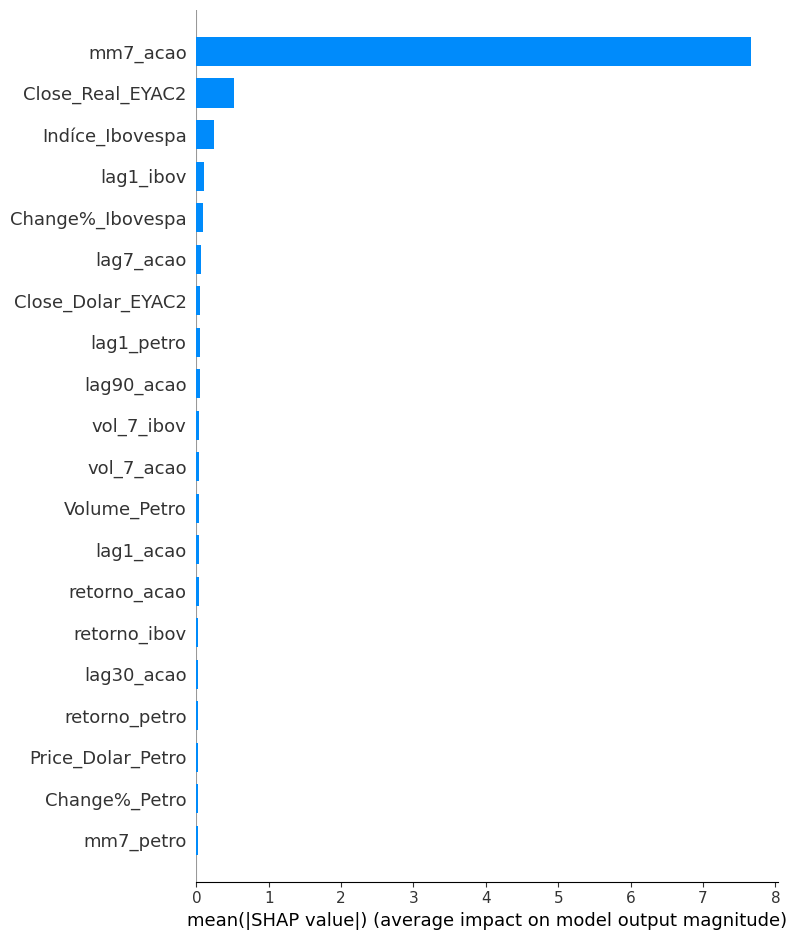

In [49]:
# Inicializar o explainer para o modelo RandomForest
explainer_rf = shap.TreeExplainer(rf_model)

# Calcular os valores SHAP para o conjunto de teste
shap_values_rf = explainer_rf.shap_values(X_test)

# Plotando o gráfico summary (gráfico de dispersão geral)
shap.summary_plot(shap_values_rf, X_test, plot_type="bar")


LinearRegression

In [50]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

# Avaliação de desempenho
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression - MAE:", mae_lr)
print("Linear Regression - RMSE:", rmse_lr)
print("Linear Regression - R²:", r2_lr)


Linear Regression - MAE: 1.5711674297971958
Linear Regression - RMSE: 1.978680844890798
Linear Regression - R²: 0.8568866142779531


RidgeRegression

In [51]:
ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Avaliação de desempenho
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression - MAE:", mae_ridge)
print("Ridge Regression - RMSE:", rmse_ridge)
print("Ridge Regression - R²:", r2_ridge)


Ridge Regression - MAE: 1.5658892871998291
Ridge Regression - RMSE: 1.9721349546760518
Ridge Regression - R²: 0.8578319460538697


LassoRegression

In [52]:
lasso_model = Lasso()
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Avaliação de desempenho
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

print("Lasso Regression - MAE:", mae_lasso)
print("Lasso Regression - RMSE:", rmse_lasso)
print("Lasso Regression - R²:", r2_lasso)


Lasso Regression - MAE: 2.5926945246146658
Lasso Regression - RMSE: 3.1031249385748336
Lasso Regression - R²: 0.6480124679338453


XGBoost

In [53]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Avaliação de desempenho
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost - MAE:", mae_xgb)
print("XGBoost - RMSE:", rmse_xgb)
print("XGBoost - R²:", r2_xgb)


XGBoost - MAE: 4.693854596863441
XGBoost - RMSE: 5.805533721493501
XGBoost - R²: -0.23200667612538362


Comparação entre modelos

In [54]:
# Criar um DataFrame para comparar as métricas
results = pd.DataFrame({
    'Model': ['Random Forest', 'Linear Regression', 'Ridge Regression', 'Lasso Regression', 'XGBoost'],
    'MAE': [mae_rf, mae_lr, mae_ridge, mae_lasso, mae_xgb],
    'RMSE': [rmse_rf, rmse_lr, rmse_ridge, rmse_lasso, rmse_xgb],
    'R²': [r2_rf, r2_lr, r2_ridge, r2_lasso, r2_xgb]
})

display(results)

,Model,MAE,RMSE,R²
0,Random Forest,5.108840,6.316628,-0.458476
1,Linear Regression,1.571167,1.978681,0.856887
2,Ridge Regression,1.565889,1.972135,0.857832
3,Lasso Regression,2.592695,3.103125,0.648012
4,XGBoost,4.693855,5.805534,-0.232007


validação cruzada temporal

In [55]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definindo TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # 5 divisões

# Função para avaliar cada modelo com TimeSeriesSplit
def evaluate_model_with_ts_split(model, X_train, y_train):
    mae_list = []
    rmse_list = []
    r2_list = []

    for train_index, val_index in tscv.split(X_train):
        X_train_split, X_val_split = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_split, y_val_split = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Treinando o modelo
        model.fit(X_train_split, y_train_split)
        
        # Fazendo previsões
        y_pred = model.predict(X_val_split)
        
        # Calculando as métricas
        mae = mean_absolute_error(y_val_split, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val_split, y_pred))
        r2 = r2_score(y_val_split, y_pred)
        
        # Armazenando as métricas para o split
        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
    # Calculando as médias das métricas
    mean_mae = np.mean(mae_list)
    mean_rmse = np.mean(rmse_list)
    mean_r2 = np.mean(r2_list)
    
    return mean_mae, mean_rmse, mean_r2

# Avaliação de cada modelo com TimeSeriesSplit
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

# Armazenando os resultados
results = []

# Avaliar todos os modelos
for name, model in models.items():
    mae, rmse, r2 = evaluate_model_with_ts_split(model, X_train, y_train)
    results.append([name, mae, rmse, r2])

# Criando um DataFrame com os resultados
results_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE', 'R²'])
display(results_df)


c:\Users\FM972EJ\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.03832e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\FM972EJ\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=7.84322e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\FM972EJ\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.31605e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\FM972EJ\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.08967e-18): result may not be accurate.
  return lina

,Model,MAE,RMSE,R²
0,Random Forest,2.480727,2.976024,0.329668
1,Linear Regression,1.573844,1.969979,0.712085
2,Ridge Regression,1.513605,1.887719,0.734555
3,Lasso Regression,2.249642,2.699049,0.447211
4,XGBoost,3.110354,3.692882,-0.131778


Visualização

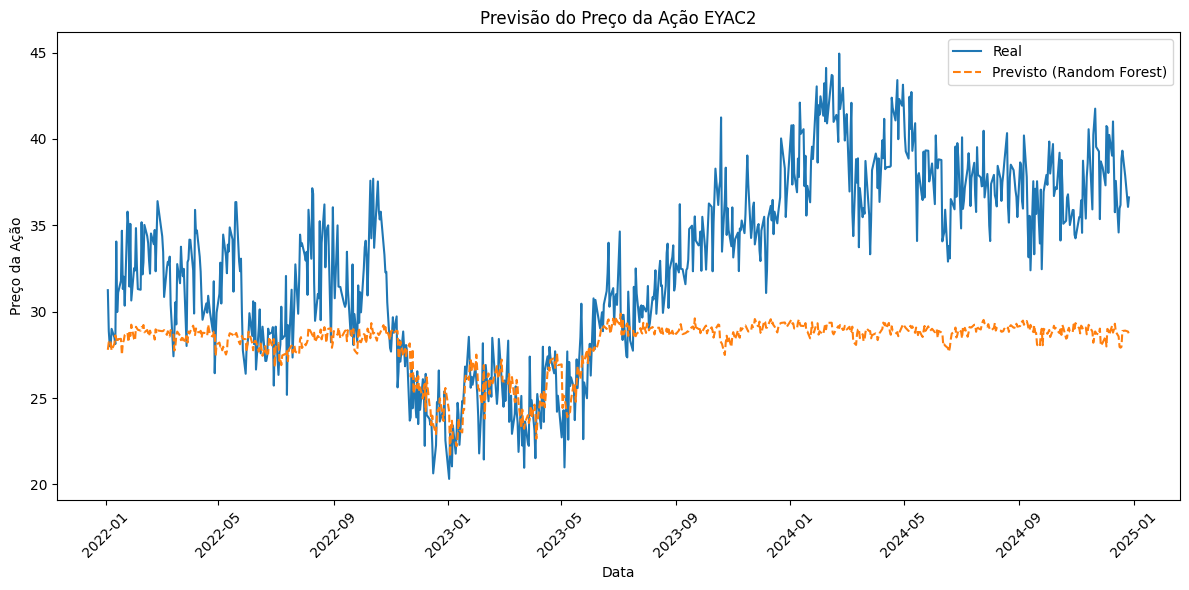

In [56]:
# Plotando as previsões vs reais
plt.figure(figsize=(12,6))
plt.plot(test['Date'], y_test, label='Real')
plt.plot(test['Date'], y_pred_rf, label='Previsto (Random Forest)', linestyle='--')  # Previsões do RandomForest
plt.legend()
plt.title("Previsão do Preço da Ação EYAC2")
plt.xlabel('Data')
plt.ylabel('Preço da Ação')
plt.xticks(rotation=45)  # Para facilitar a leitura das datas
plt.tight_layout()  # Ajustar para que os elementos não se sobreponham
plt.show()


Erros residuais

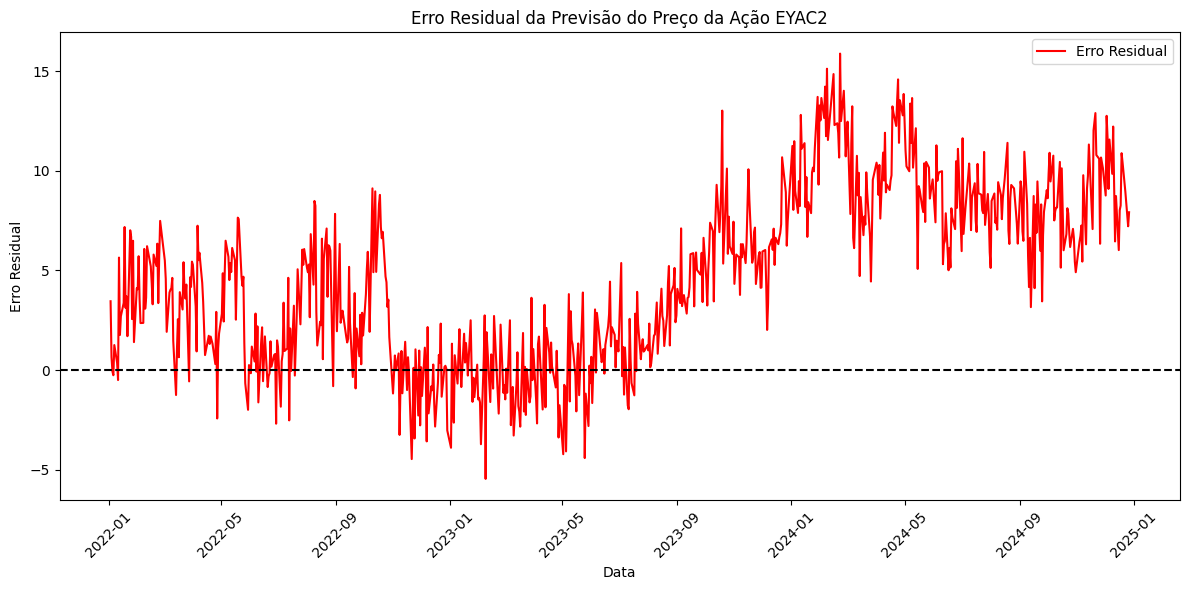

In [57]:
# Calculando os resíduos
residuals = y_test - y_pred_rf

# Plotando os resíduos
plt.figure(figsize=(12,6))
plt.plot(test['Date'], residuals, label='Erro Residual', color='red')
plt.axhline(0, color='black', linestyle='--')  # Linha horizontal em y=0
plt.legend()
plt.title("Erro Residual da Previsão do Preço da Ação EYAC2")
plt.xlabel('Data')
plt.ylabel('Erro Residual')
plt.xticks(rotation=45)  # Para facilitar a leitura das datas
plt.tight_layout()  # Ajuste para que os elementos não se sobreponham
plt.show()


Previsões 2025

In [69]:
# Re-treinar o modelo com dados até 2024
train_full = df_model[df_model['Date'] < '2025-01-01']
X_train_full = train_full.drop(columns=['Date', 'Datetime', 'target'])
y_train_full = train_full['target']

# Re-treinar o modelo com o conjunto completo de dados até 2024
rf_model.fit(X_train_full, y_train_full)


RandomForestRegressor(random_state=42)

In [72]:
# Verifique as colunas usadas no treinamento
print(X_train_full.columns)


Index(['Close_Real_EYAC2', 'Volume_EYAC2', 'Close_Dolar_EYAC2',
       'Price_Dolar_Petro', 'Volume_Petro', 'Change%_Petro', 'Indíce_Ibovespa',
       'Change%_Ibovespa', 'Value_IPCA', 'retorno_acao', 'retorno_petro',
       'retorno_ibov', 'mm7_acao', 'mm7_petro', 'vol_7_acao', 'vol_7_ibov',
       'lag1_acao', 'lag7_acao', 'lag30_acao', 'lag90_acao', 'lag1_petro',
       'lag1_ibov', 'lag1_ipca'],
      dtype='object')


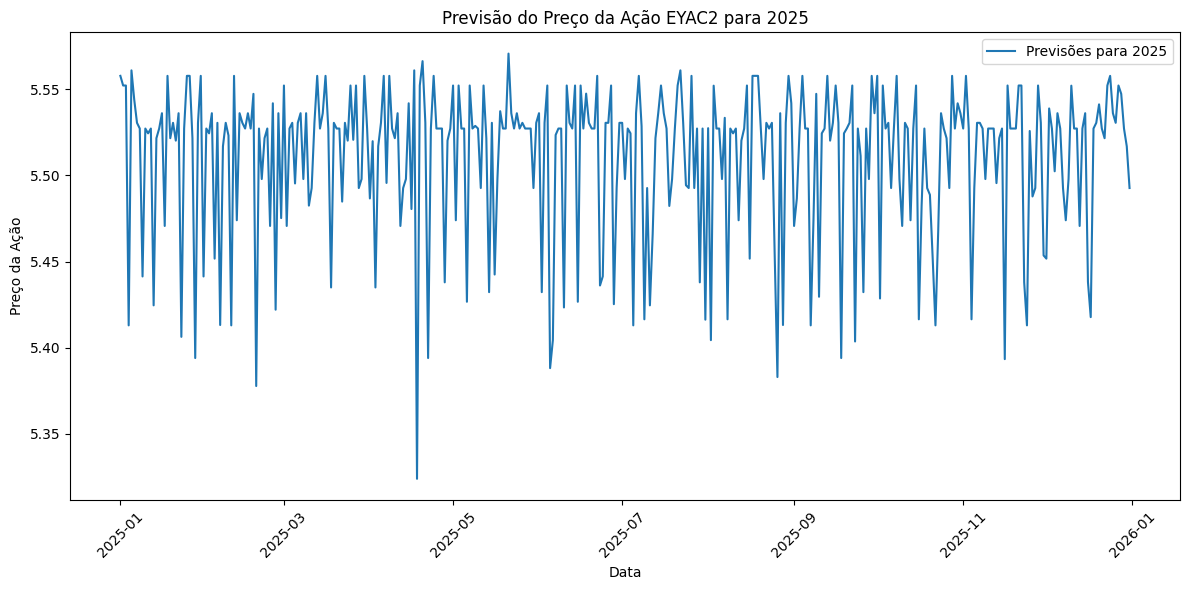

In [74]:
# Gerar datas para o ano de 2025
dates_2025 = pd.date_range(start='2025-01-01', end='2025-12-31', freq='D')

# Criar um DataFrame para 2025 com as variáveis corretas
# Substitua os valores aleatórios pelos dados reais ou previstos para 2025

X_2025 = pd.DataFrame({
    'Close_Real_EYAC2': np.random.random(len(dates_2025)),  # Substitua com dados reais
    'Volume_EYAC2': np.random.random(len(dates_2025)),  # Substitua com dados reais
    'Close_Dolar_EYAC2': np.random.random(len(dates_2025)),  # Substitua com dados reais
    'Price_Dolar_Petro': np.random.random(len(dates_2025)),  # Substitua com dados reais
    'Volume_Petro': np.random.random(len(dates_2025)),  # Substitua com dados reais
    'Change%_Petro': np.random.random(len(dates_2025)),  # Substitua com dados reais
    'Indíce_Ibovespa': np.random.random(len(dates_2025)),  # Substitua com dados reais
    'Change%_Ibovespa': np.random.random(len(dates_2025)),  # Corrigido o nome da coluna aqui
    'Value_IPCA': np.random.random(len(dates_2025)),  # Substitua com dados reais
    'retorno_acao': np.random.random(len(dates_2025)),  # Substitua com dados reais
    'retorno_petro': np.random.random(len(dates_2025)),  # Substitua com dados reais
    'retorno_ibov': np.random.random(len(dates_2025)),  # Substitua com dados reais
    'mm7_acao': np.random.random(len(dates_2025)),  # Substitua com dados reais
    'mm7_petro': np.random.random(len(dates_2025)),  # Substitua com dados reais
    'vol_7_acao': np.random.random(len(dates_2025)),  # Substitua com dados reais
    'vol_7_ibov': np.random.random(len(dates_2025)),  # Substitua com dados reais
    'lag1_acao': np.random.random(len(dates_2025)),  # Substitua com dados reais
    'lag7_acao': np.random.random(len(dates_2025)),  # Substitua com dados reais
    'lag30_acao': np.random.random(len(dates_2025)),  # Substitua com dados reais
    'lag90_acao': np.random.random(len(dates_2025)),  # Substitua com dados reais
    'lag1_petro': np.random.random(len(dates_2025)),  # Substitua com dados reais
    'lag1_ibov': np.random.random(len(dates_2025)),  # Substitua com dados reais
    'lag1_ipca': np.random.random(len(dates_2025)),  # Substitua com dados reais
})

# Organizar as colunas para garantir que elas sigam a mesma ordem do treinamento
columns_needed = X_train_full.columns
X_2025 = X_2025[columns_needed]

# Agora, faça a previsão para 2025
predictions_2025 = rf_model.predict(X_2025)

# Criar um DataFrame para armazenar as previsões
predictions_df = pd.DataFrame({
    'Date': dates_2025,
    'Predicted_Close_Real_EYAC2': predictions_2025
})

# Visualizar as previsões para 2025
plt.figure(figsize=(12,6))
plt.plot(predictions_df['Date'], predictions_df['Predicted_Close_Real_EYAC2'], label='Previsões para 2025')
plt.legend()
plt.title("Previsão do Preço da Ação EYAC2 para 2025")
plt.xlabel('Data')
plt.ylabel('Preço da Ação')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Ridge Model

Previsão recursiva

In [66]:
from datetime import timedelta

# Definir o último ponto conhecido (24/12/2024)
last_known_date = df_model['Date'].max()

# Criar cópia da base para simular o futuro
future_df = df_model.copy()
future_preds = []

# Definindo o número de dias de previsão (aproximadamente 250 pregões)
for i in range(250):
    # Última linha conhecida (última previsão feita)
    last_row = future_df.iloc[-1]

    # Gerar nova linha com features para o próximo dia
    next_date = last_row['Date'] + timedelta(days=1)

    # Adicionando todas as features que o modelo espera
    new_row = {
    'Date': next_date,
    'lag1_acao': last_row['Close_Real_EYAC2'],
    'lag7_acao': last_row['Close_Real_EYAC2'],
    'lag30_acao': last_row['Close_Real_EYAC2'],
    'lag90_acao': last_row['Close_Real_EYAC2'],
    'lag1_petro': last_row['Price_Dolar_Petro'],
    'lag1_ibov': last_row['Indíce_Ibovespa'],
    'lag1_ipca': last_row['Value_IPCA'],
    'retorno_acao': last_row['retorno_acao'],
    'retorno_petro': last_row['retorno_petro'],
    'retorno_ibov': last_row['retorno_ibov'],
    'mm7_acao': last_row['mm7_acao'],
    'mm7_petro': last_row['mm7_petro'],
    'vol_7_acao': last_row['vol_7_acao'],
    'vol_7_ibov': last_row['vol_7_ibov'],
    'Change%_Petro': last_row['Change%_Petro'],
    'Indíce_Ibovespa': last_row['Indíce_Ibovespa'],
    'Price_Dolar_Petro': last_row['Price_Dolar_Petro'],
    'Value_IPCA': last_row['Value_IPCA'],
    'Close_Dolar_EYAC2': last_row['Close_Dolar_EYAC2'],
    'Volume_Petro': last_row['Volume_Petro'],
    'Volume_EYAC2': last_row['Volume_EYAC2'],
    'Change%_Ibovespa': last_row['Change%_Ibovespa'],
    'Close_Real_EYAC2': last_row['Close_Real_EYAC2']  # Adicionando a coluna 'Close_Real_EYAC2'
}


    # Criando o DataFrame para a previsão
    input_df = pd.DataFrame([new_row]).drop(columns=['Date'])  # Não inclua 'Date' como feature

    # Garantir que o input_df tenha todas as features que o modelo espera
    # Reorganizando as colunas para a mesma ordem que o modelo foi treinado
    input_df = input_df[model.feature_names_in_]

    # Garantir que o input_df tenha todas as colunas exigidas pelo modelo
    missing_columns = set(model.feature_names_in_) - set(input_df.columns)
    if missing_columns:
        print(f"Faltando as seguintes colunas no input_df: {missing_columns}")
    else:
        input_df = input_df[model.feature_names_in_]


    # Fazer a previsão com o modelo Ridge
    y_pred = ridge_model.predict(input_df)[0]

    # Salvar a previsão
    new_row['Close_Real_EYAC2'] = y_pred
    future_preds.append((next_date, y_pred))

    # Adicionar a nova linha à base simulada
    future_df = pd.concat([future_df, pd.DataFrame([new_row])], ignore_index=True)


c:\Users\FM972EJ\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\FM972EJ\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\FM972EJ\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\FM972EJ\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
c:\Users\FM972EJ\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  

Dataframe da previsão

In [67]:
# Criar um DataFrame com as previsões de 2025
future_pred_df = pd.DataFrame(future_preds, columns=['Date', 'Predicted_Close_Real_EYAC2'])


Visualização da Previsão

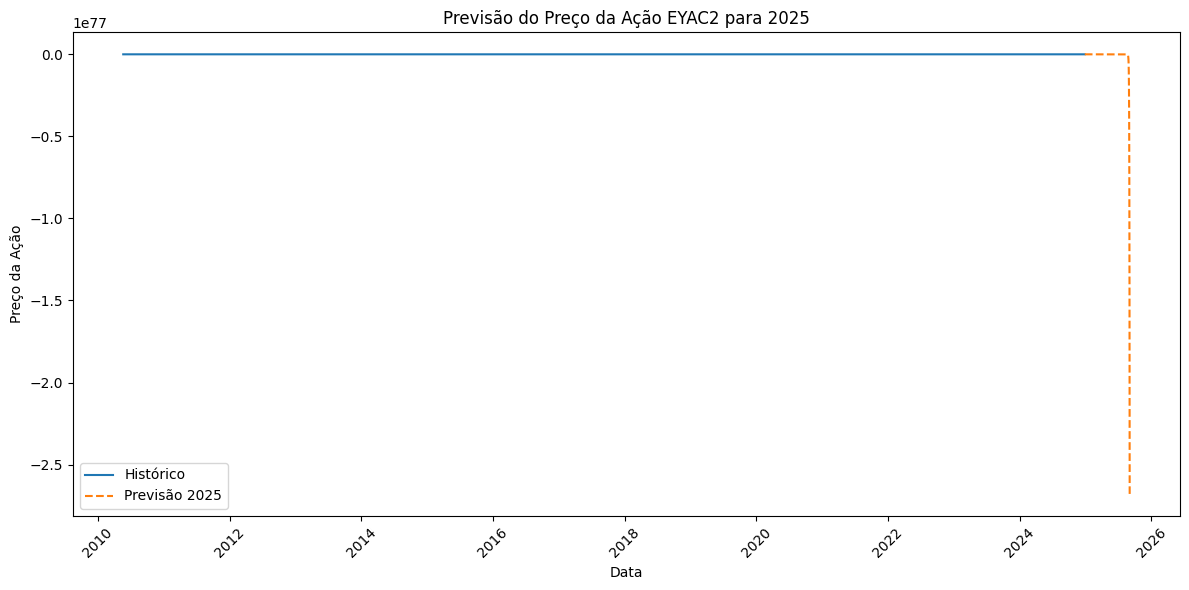

In [ ]:
# Plotando a previsão do preço da ação para 2025
plt.figure(figsize=(12,6))
plt.plot(df_model['Date'], df_model['Close_Real_EYAC2'], label='Histórico')  # Dados históricos
plt.plot(future_pred_df['Date'], future_pred_df['Predicted_Close_Real_EYAC2'], label='Previsão 2025', linestyle='--')  # Previsões
plt.legend()
plt.title("Previsão do Preço da Ação EYAC2 para 2025")
plt.xlabel('Data')
plt.ylabel('Preço da Ação')
plt.xticks(rotation=45)  # Para facilitar a leitura das datas
plt.tight_layout()  # Ajuste para que os elementos não se sobreponham
plt.show()
